[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/accdavlo/calcolo-scientifico/blob/main/codes/solutions/transport_FD.ipynb)

# Transport equation

In this notebook we will solve the 1D Transport (hyperbolic) equation given 
$$\partial_t u +a\partial_{x} u = 0 .$$


In [75]:
try:
    from geometry import *
except ImportError:
    !wget https://raw.githubusercontent.com/accdavlo/calcolo-scientifico/refs/heads/main/codes/solutions/geometry.py -O geometry.py
    from geometry import *

import numpy as np
import matplotlib.pyplot as plt

### Explicit Euler with different numerical fluxes
$$
\frac{u^{n+1}_i-u^n_i}{\Delta t} + \frac{\hat{f}_{i+1/2} - \hat{f}_{i-1/2}}{\Delta x}=0 
$$

## Other spatial discretizations!

In [64]:
# Define some spatial discretizations for linear advection as a function of
# um1 $u_{i-1}$, u $u_i$ and up1 $u_{i+1}$
# a speed, dt timestep, dx spacestep

class Burgers:
    def __init__(self,a=1.):
        self.a=a
        self.flux_minimum=0.
    def flux(self,u):
        return self.a*u**2/2.
    def jac(self,u):
        return self.a*u
    def entropy(self,u):
        return self.a*u**2/2.
    def entropy_flux(self,u):
        return self.a*u**3/3.
    def max_eig(self,u):
        return np.abs(u)


# Numerical fluxes
def Lax_Friedrichs(problem, uL,uR, fL, fR, dt,dx):
    fnum = (fL+fR)/2. - dx/dt/2*(uR-uL)
    return fnum

def Rusanov(problem, uL,uR, fL, fR, dt,dx):
    fnum = (fL+fR)/2. - np.maximum(problem.max_eig(uL),problem.max_eig(uR))/2*(uR-uL)
    return fnum

def Engquist_Osher(problem, uL,uR, fL, fR, dt,dx):
    fnum = problem.flux(np.maximum(uL,problem.flux_minimum))+\
            problem.flux(np.minimum(uR,problem.flux_minimum))
    return fnum

def linearized_Roe(problem, uL,uR, fL, fR, dt,dx):
    a =  (fR-fL)/(uR-uL)
    equal_idxs = np.abs(uR-uL)<1e-13
    a[equal_idxs] = problem.jac(uR[equal_idxs])
    fnum = (a>=0)*fL + (a<0)*fR 
    return fnum




class SpatialDiscretizationAdvection:
    def __init__(self,method, boundary):
        self.boundary = boundary


            
    def eval(self,u,a,dt,dx):
        if self.boundary=="periodic":
            u_red = u[:-1]
            # u_{i+1} using periodic BC
            up1 = np.roll(u_red,-1)
            # u_{i+2} using periodic BC
            up2 = np.roll(up1,-1)
            # u_{i-1} using periodic BC
            um1 = np.roll(u_red,1)
            # u_{i-2} using periodic BC
            um2 = np.roll(um1,1)
            adv_red = self.advection(um2,um1,u_red,up1,up2,a,dt,dx)
            adv = np.concatenate([adv_red, [adv_red[0]]])
        return adv


In [65]:

class Advection_explicit_euler:
    def __init__(self, geom, problem, T_end, u0_lambda, CFL,\
                 spatial_discretization_type = "Lax_Friedrics",
                 dt_save = 0.1, u_ex_lambda = None, boundary = ["periodic", "periodic"]):
        self.geom = geom
        self.problem = problem
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.add_ghosts()
        self.u0 = self.u0_lambda(self.xx_ghosts)
        self.CFL = CFL
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        self.Nt_max = 1e6
        self.boundary = boundary
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda
        
        self.method = spatial_discretization_type
        if self.method == "Lax_Friedrichs":
            self.num_flux = Lax_Friedrichs
        elif self.method =="Rusanov":
            self.num_flux = Rusanov
        elif self.method =="Engquist_Osher":
            self.num_flux = Engquist_Osher
        elif self.method =="linearized_Roe":
            self.num_flux = linearized_Roe



    def set_geom(self,dx=None,Nx=None, geom=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.add_ghosts()
        self.u0 = self.u0_lambda(self.xx_ghosts)

    def add_ghosts(self):
        self.xx_ghosts = np.concatenate([[self.geom.xx[0]-self.geom.dx], self.geom.xx, [self.geom.xx[-1]+self.geom.dx]])
        self.n_ghosts = 1
        
    def apply_bc(self, u):
        if self.boundary["left"][0]=="periodic" and self.boundary["right"][0]=="periodic":
            u[0] = u[-3]
            u[-1] = u[2]
        else:
            if self.boundary["left"][0]=="dirichlet":
                u[0] = self.boundary["left"][1]
            else: #Neumann homogeneous
                u[0] = u[1]
            if self.boundary["right"][0]=="dirichlet":
                u[-1] = self.boundary["right"][1]
            else: #Neumann homogeneous
                u[-1] = u[-2]
    
    def set_dt(self,un):
        # Setting dt so that it respects the CFL constraints
        self.dt = self.geom.dx*self.CFL/np.max(self.problem.max_eig(un))
    
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0[1:-1]
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)
        self.apply_bc(un)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt_max and time<self.T_end):

            self.set_dt(un)
            
            time=time+self.dt
            time_save = time_save+self.dt
            it+=1

            f = self.problem.flux(un)
            fnum = self.num_flux(self.problem, un[:-1],un[1:], f[:-1], f[1:], self.dt,self.geom.dx)
            
            un1[1:-1] = un[1:-1] - self.dt/self.geom.dx * (fnum[1:]-fnum[:-1])
            self.apply_bc(un1)

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1[1:-1]
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            # print("Final error ",self.error)
        return self.geom.xx, un1[1:-1]


In [66]:
problem = Burgers()

geom = Geometry1D(0,1.,1000)
CFL = 0.9
T_end = 0.45
u0_lambda = lambda x: np.sin(2*np.pi*x)
u0_lambda = lambda x: -2.*(x>0.5)+2

spatial_discretization_type = "Rusanov"#"Lax_Friedrichs"
boundary = dict()
boundary["left"] = ["periodic",None]
boundary["right"] = ["periodic",None]
boundary = dict()
boundary["left"] = ["dirichlet",u0_lambda(geom.x_left)]
boundary["right"] = ["neumann",0.]

EE_advection = Advection_explicit_euler( geom, problem, T_end, u0_lambda, CFL, \
                     spatial_discretization_type=spatial_discretization_type,
                 dt_save = 0.1, boundary=boundary)


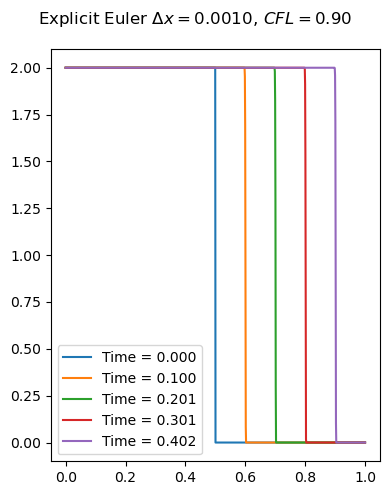

In [67]:
xx, un1 = EE_advection.evolve()

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(EE_advection.times):
    ax1.plot(geom.xx, EE_advection.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, EE_advection.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, CFL=%1.2f$"%(geom.dx,EE_advection.CFL))
plt.tight_layout()
#plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.pdf"%(geom.dx,dt))
#plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()


## Comparison of different methods

Method =  Rusanov
Method =  linearized_Roe
Method =  Lax_Friedrichs
Method =  Engquist_Osher


/tmp/ipykernel_294298/4212928839.py:36: RuntimeWarning: invalid value encountered in divide
  a =  (fR-fL)/(uR-uL)


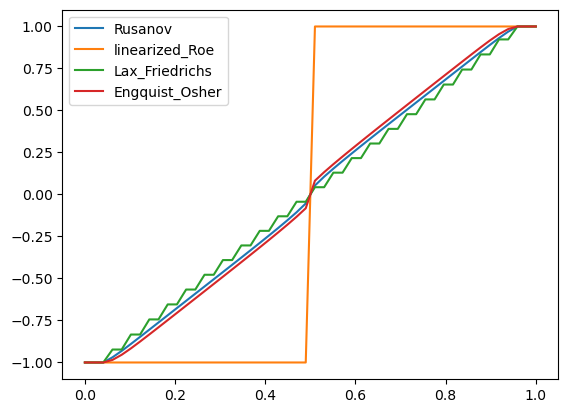

In [74]:
problem = Burgers()

geom = Geometry1D(0,1.,50)
CFL = 0.9
T_end = 0.4
u0_lambda = lambda x: np.sin(2*np.pi*x)
u0_lambda = lambda x: 2.*(x>0.5)-1.

spatial_discretization_type = "Rusanov"#"Lax_Friedrichs"
boundary = dict()
boundary["left"] = ["periodic",None]
boundary["right"] = ["periodic",None]

boundary = dict()
boundary["left"] = ["dirichlet",u0_lambda(geom.x_left)]
boundary["right"] = ["neumann",0.]


spatial_discretizations  = ["Rusanov","linearized_Roe","Lax_Friedrichs","Engquist_Osher"] #,"central"

for spatial_discretization_type in spatial_discretizations:
    print("Method = ",spatial_discretization_type)
    EE_advection = Advection_explicit_euler( geom, problem, T_end, u0_lambda, CFL, \
                     spatial_discretization_type=spatial_discretization_type,
                    dt_save = 0.1,boundary=boundary)
    xx,un1 = EE_advection.evolve()
    plt.plot(xx,un1, label=spatial_discretization_type)


plt.legend()

## Exercises
1. Check the order of accuracy of these methods on a smooth solution
1. Check if they converge towards the entropy solution in case of a shock and a rarefaction wave.